In [11]:
import numpy as np
import numpy.random as rd
import pystan
from pystan import StanModel
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
class generate_ARMA_data():
    def __init__(self, ar_param=[.7, .3], ma_param=[.7, .3], size=500):
        self.ar_params = np.array(ar_param)
        self.ma_params = np.array(ma_param)
        self.size = size
        self.n_ar = len(self.ar_params)
        self.n_ma = len(self.ma_params)
        self.generate()
    
    def generate(self):
        ar = np.r_[1, -self.ar_params]
        ma = np.r_[1, self.ma_params]
        self.y = arma_generate_sample(ar, ma, self.size)
    
    def get_data(self):
        return self.y.copy()
    

In [13]:
dat = generate_ARMA_data(ar_param=[], ma_param=[.7, .3])

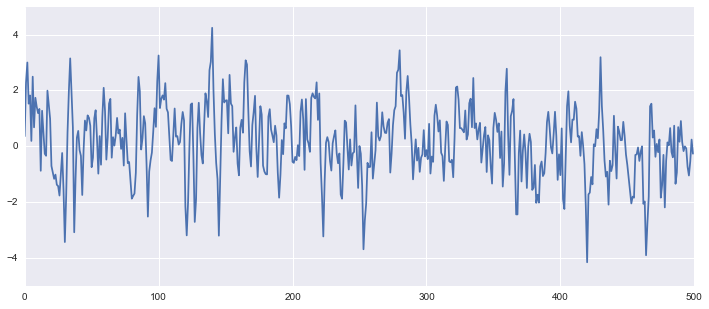

In [14]:
dat.generate()
plt.figure(figsize=(12,5))
plt.plot(dat.get_data())

In [20]:
class Stan_ARMA_estimator():
    def __init__(self, data, n_ar, n_ma):
        self.code = """
        data {
            int<lower=0> Q;         // num previous noise terms
            int<lower=3> T;         // num observations
            vector[T] y;            // observation at time t
        }
        parameters {
            real mu;                // mean
            real<lower=0> sigma;    // error scale
            vector[Q] theta;        // error coeff, lag -t
        } model {
            vector[T] epsilon;      // error term at time t
            vector[T] eta;
            for (t in 1:T) {
                epsilon[t] <- y[t] - mu;
                for (q in 1:min(t-1,Q))
                    epsilon[t] <- epsilon[t] - theta[q] * epsilon[t - q];
            }
            mu ~ cauchy(0,2.5);
            theta ~ cauchy(0,2.5);
            sigma ~ cauchy(0,2.5);
            for (t in 1:T) {
                eta[t] <- mu;
                for (q in 1:min(t-1,Q))
                    eta[t] <- eta[t] + theta[q] * epsilon[t - q];
            }
            y ~ normal(eta,sigma);
        }
        """
        
        self.ts_dat = {'T': len(data), 'Q': n_ma, 'y': data}
        
    def build(self):
        self.stm = StanModel(model_code=self.code)
        
    def fit(self,iter=2000, chains=4):
        self.fit = self.stm.sampling(data=self.ts_dat, iter=iter, chains=chains)
        self.la = self.fit.extract(permuted=True)  # return a dictionary of arrays
        self.names = self.fit.model_pars 
        self.n_param = np.sum([1 if len(x) == 0 else x[0] for x in self.fit.par_dims])
        
    def plot(self):
        f, axes = plt.subplots(self.n_param, 2,figsize=(15, 4*self.n_param))
        cnt = 0
        for name in self.names:
            dat = self.la[name]
            if dat.ndim == 2:
                for j in range(dat.shape[1]):
                    d = dat[:,j]
                    sns.distplot(d, hist=False, rug=True, ax=axes[cnt, 0])
                    sns.tsplot(d,   alpha=0.8, lw=1, ax=axes[cnt, 1])
                    cnt += 1
            else:
                sns.distplot(dat, hist=False, rug=True, ax=axes[cnt, 0])
                sns.tsplot(dat,   alpha=0.8, lw=1, ax=axes[cnt, 1])
                cnt += 1

        name_list = []
        for name in self.names:
            dat = self.la[name]
            if dat.ndim == 2:
                for i in range(dat.shape[1]):
                    name_list.append("{}{}".format(name,i+1))
            else:
                name_list.append(name)

        for i in range(2):
            for j, t in enumerate(name_list):
                axes[j, i].set_title(t)
        plt.show()
        
    def get_estimated_params(self):
        for f, n in zip(self.fit.summary()['summary'][:,0], self.fit.summary()['summary_rownames']):
            print n, f
        
    def summary(self):
        print(self.fit)

In [29]:
model = Stan_ARMA_estimator(dat.get_data(), dat.n_ar, dat.n_ma)

In [30]:
model.build()

In [31]:
model.fit()

/Users/matsuken/anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/matsuken/anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/matsuken/anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/matsuken/anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel

In [32]:
model.summary()

Inference for Stan model: anon_model_1d857104ab64495339f5ec7ee94023ea.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         0.15  2.9e-3   0.09  -0.03   0.09   0.15   0.21   0.34 1016.0    1.0
sigma      0.98  9.9e-4   0.03   0.92   0.96   0.98    1.0   1.04 1027.0    1.0
theta[0]   0.73  1.3e-3   0.04   0.65    0.7   0.73   0.76   0.81  975.0    1.0
theta[1]   0.38  1.3e-3   0.04    0.3   0.35   0.38   0.41   0.46  980.0    1.0
lp__     -238.0    0.05   1.41 -241.7 -238.7 -237.7 -237.0 -236.2  789.0    1.0

Samples were drawn using NUTS(diag_e) at Fri Sep 25 22:02:25 2015.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


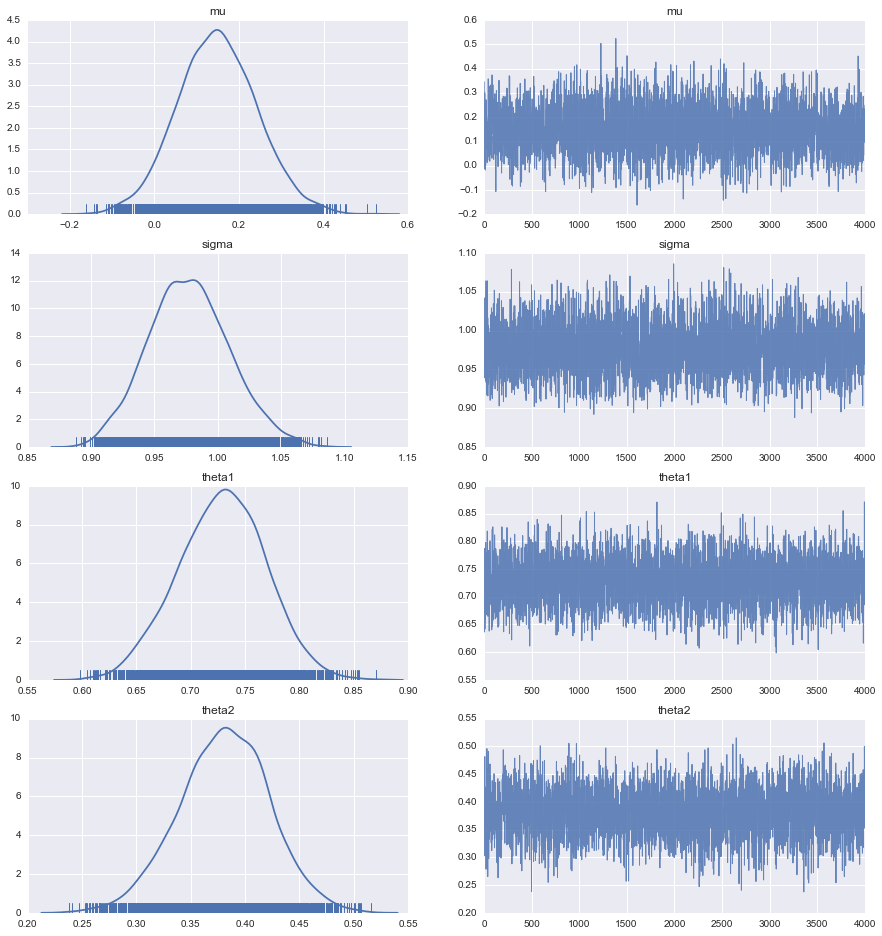

In [33]:
model.plot()